<a href="https://colab.research.google.com/github/MastafaF/Lab2_EPITA/blob/main/Lab2_EPITA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# II. NLP across languages, a multilingual setting

In [ ]:
!wget https://github.com/HoneyBunny0/NLP3/raw/main/LAB2/MUSE.zip
!unzip MUSE.zip

In [2]:
!curl -Lo MUSE/data/wiki.fr.vec https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fr.vec
!curl -Lo MUSE/data/wiki.en.vec https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2886M  100 2886M    0     0  14.0M      0  0:03:24  0:03:24 --:--:-- 11.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6291M  100 6291M    0     0  13.9M      0  0:07:32  0:07:32 --:--:-- 16.7M


In [3]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.7 MB/s eta 0:00:00


In [4]:
%cd MUSE

/content/MUSE


## Training with wikipedias's datas

In [8]:
!python unsupervised.py --src_lang fr --tgt_lang en --src_emb data/wiki.fr.vec --tgt_emb data/wiki.en.vec --n_epochs 1 --exp_name "fr_en" --exp_path "./" --export ""

INFO - 01/11/23 22:24:49 - 0:00:00 - ============ Initialized logger ============
INFO - 01/11/23 22:24:49 - 0:00:00 - adversarial: True
                                     batch_size: 32
                                     cuda: True
                                     dico_build: S2T
                                     dico_eval: default
                                     dico_max_rank: 15000
                                     dico_max_size: 0
                                     dico_method: csls_knn_10
                                     dico_min_size: 0
                                     dico_threshold: 0
                                     dis_clip_weights: 0
                                     dis_dropout: 0.0
                                     dis_hid_dim: 2048
                                     dis_input_dropout: 0.1
                                     dis_lambda: 1
                                     dis_layers: 2
                                     dis_mo

## Getting the mapping output

In [9]:
id = !ls fr_en

In [10]:
import torch
mapping_data = torch.load("fr_en/" + id[0] + "/best_mapping.pth")
mapping = torch.nn.Linear(300,300, bias=False)
mapping.weight.data = torch.from_numpy(mapping_data)

## Getting the datas

In [11]:
from gensim.models import KeyedVectors
fr = KeyedVectors.load_word2vec_format('data/wiki.fr.vec', binary=False)
en = KeyedVectors.load_word2vec_format('data/wiki.en.vec', binary=False)

## Testing the mapping

In [12]:
words_fr = ["beau", "clavier", "monsieur", "cheval"]
words_en = ["beautiful", "keyboard", "mister", "horse"]

encoded_words_fr = [] 
encoded_words_en = [] 

for word in words_fr:
  encoded_words_fr.append(fr[word])
for word in words_en:
  encoded_words_en.append(en[word])

In [13]:
mapped_words = []

for word in encoded_words_fr:
  mapped_words.append(mapping(torch.from_numpy(word)).detach().numpy())

<ipython-input-13-954f0fa6b3af>:4: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  mapped_words.append(mapping(torch.from_numpy(word)).detach().numpy())


In [14]:
from sklearn.decomposition import TruncatedSVD

def reduce_to_k_dim(M, k=2):
    n_iters = 10     
    M_reduced = None

    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)

    return M_reduced



## Vizualizing the mapping result

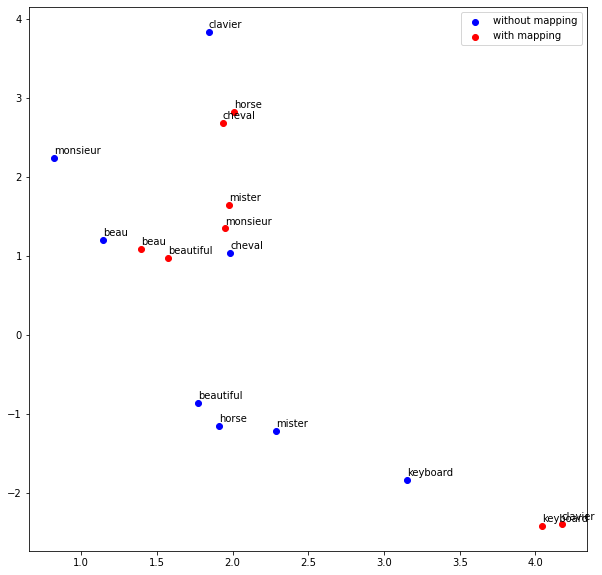

In [19]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10,10)
points = reduce_to_k_dim(encoded_words_fr + encoded_words_en)
mapPoints = reduce_to_k_dim(mapped_words + encoded_words_en)
labels = words_fr + words_en

plt.scatter([el[0] for el in points], [el[1] for el in points], color="blue", label="without mapping")
plt.scatter([el[0] for el in mapPoints], [el[1] for el in mapPoints], color="red", label="with mapping")


for i, txt in enumerate(labels):
    plt.annotate(txt, (points[i][0], points[i][1]+0.05))
    plt.annotate(txt, (mapPoints[i][0], mapPoints[i][1]+0.05))

plt.legend()

## Apply the translation approach

In [17]:
import math

def translation(word, points, mapPoints):
    closest_distance = float('inf')
    closest_point = None
    for point in point_list:
        distance = math.sqrt((point[0] - reference[0])**2 + (point[1] - reference[1])**2)
        if distance < closest_distance:
            closest_distance = distance
            closest_point = point
    return closest_point
